In [1]:
import pathlib

from tensorflow import keras
import numpy as np
import pandas as pd

from utils.misc import get_items_on_path
from utils.vision.transformation import rle_encode
from training import data_pipeline, prepare_X_and_y

from sklearn.preprocessing import Binarizer

from hydra import initialize, compose
from omegaconf import OmegaConf
initialize("./configs")

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cfg = compose(config_name="config.yaml")
np.random.seed(cfg.project_setup.RANDOM_STATE_N)

PATH_PARENT = pathlib.Path("__file__").absolute().parents[0]
PATH_TEST_DATA = PATH_PARENT.joinpath(cfg.project_setup.paths.data.TEST_IMAGE_FOLDER)
PATH_MODEL = PATH_PARENT.joinpath("multirun", "2022-02-12", "12-14-51", "0", "model")

INPUT_IMG_SHAPE = (cfg.preprocessing.INPUT_SHAPE.HEIGHT, cfg.preprocessing.INPUT_SHAPE.WIDTH)

In [3]:
# load trained model & test images
model = keras.models.load_model(PATH_MODEL)

test_images_paths = get_items_on_path(PATH_TEST_DATA)
test_data = data_pipeline(cfg=cfg, images_path=test_images_paths, 
                          images_shape=INPUT_IMG_SHAPE, prepare_y=False)

X = [test_data[image_id]["X"]["X_transformed"] for image_id in test_data]
X = np.array(X)

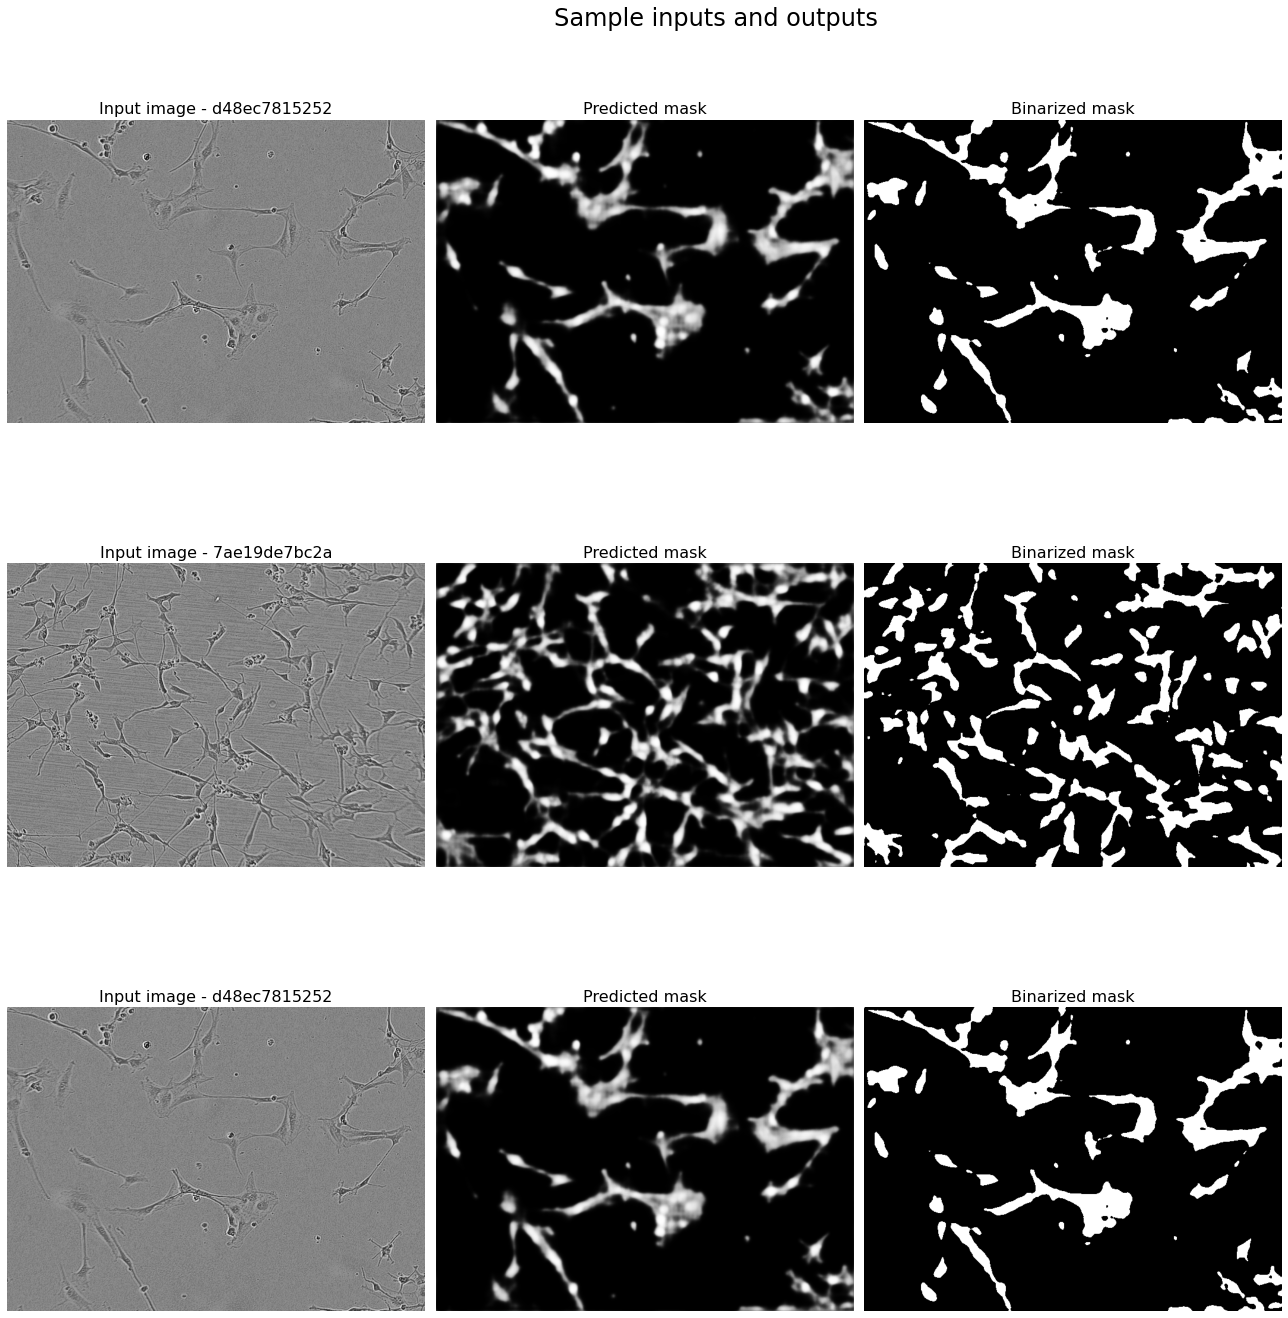

In [4]:
### Change this logic, so its looping instead


# Visualizing Test Images and its mask predictions
num_preds = 3
sample_pred_ids = np.random.randint(len(X), size = num_preds)

pred_y = model.predict(X[sample_pred_ids])
pred_y_mask = Binarizer(threshold = 0.4).transform(pred_y.reshape(-1, 1)).reshape(pred_y.shape)

plt.figure(figsize = (20 , 20))
for i in range(num_preds):
    
    image_id = list(test_data.keys())[sample_pred_ids[i]]
    
    plt.subplot(num_preds, 3, (3 * i) + 1)
    plt.imshow(X[sample_pred_ids[i]], cmap = 'gray')
    plt.axis('off')
    plt.title(f'Input image - {image_id}', fontsize = 16)
    
    plt.subplot(num_preds, 3, (3 * i) + 2)
    plt.imshow(pred_y[i], cmap = 'gray')
    plt.axis('off')
    plt.title('Predicted mask', fontsize = 16)
    
    plt.subplot(num_preds, 3, (3 * i) + 3)
    plt.imshow(pred_y_mask[i], cmap = 'gray')
    plt.axis('off')
    plt.title('Binarized mask', fontsize = 16)
    
plt.suptitle("Sample inputs and outputs", fontsize = 24)
plt.tight_layout(rect = [0, 0, 0.90, 1])
plt.show()

In [5]:
img_ids = []
rle_encondings = []
for i in range(num_preds):
    
    img_id = list(test_data.keys())[sample_pred_ids[i]]
    img_ids.append(img_id)
    
    rle_encoding = rle_encode(pred_y_mask[i])
    rle_encondings.append(rle_encoding)

sample_submission = pd.DataFrame({
    'id': img_ids,
    'predicted': rle_encondings
})

sample_submission

,id,predicted
0,d48ec7815252,1 1 187 31 329 12 705 1 890 32 1033 12 1594 32...
1,7ae19de7bc2a,53 13 142 7 197 5 280 13 448 12 500 35 549 43 ...
2,d48ec7815252,1 1 187 31 329 12 705 1 890 32 1033 12 1594 32...


In [ ]:
### There should be per ID, multiple lines of predictions

In [6]:
pred_y_mask[0].max() + 1

2.0

In [7]:
masks = []
for i in range(1, pred_y_mask[0].max() +1):
    masks.append(rle_encode(pred_y_mask[0]==i))

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [ ]:
rle_encode(pred_y_mask[0]==1)

In [ ]:
pred_y_mask[2].max()